<img src="scheme.png" alt="drawing" width="50%"/>

### Imports

In [1]:
from typing import Iterable, List, Dict
import os
import gc

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Constants

In [17]:
PATH_TO_DATA = "c:/Hydraulics/data/"
NUMBER_OF_PROFILES = 2205
PROFILE_MAX_SAMPLE_RATE = 6000
TARGET_NAMES = ["cooler", "valve", "leakage", "accumulator", "stable"]

PLOT_STYLE = "darkgrid"

### Load data

In [4]:
read_files_config = [
    {"name": "CE", "resample_coeff": 100},
    {"name": "CP", "resample_coeff": 100},
    {"name": "EPS1", "resample_coeff": 1},
    {"name": "FS1", "resample_coeff": 10},
    {"name": "FS2", "resample_coeff": 10},
    {"name": "PS1", "resample_coeff": 1},
    {"name": "PS2", "resample_coeff": 1},
    {"name": "PS3", "resample_coeff": 1},
    {"name": "PS4", "resample_coeff": 1},
    {"name": "PS5", "resample_coeff": 1},
    {"name": "PS6", "resample_coeff": 1},
    {"name": "SE", "resample_coeff": 100},
    {"name": "TS1", "resample_coeff": 100},
    {"name": "TS2", "resample_coeff": 100},
    {"name": "TS3", "resample_coeff": 100},
    {"name": "TS4", "resample_coeff": 100},
    {"name": "VS1", "resample_coeff": 100},
]

In [10]:
def get_files_with_resample(config: List[Dict]) -> Iterable[np.ndarray]:
    for file in config:
        data = np.genfromtxt(PATH_TO_DATA + file["name"] + ".txt", dtype=float, delimiter='\t')
        yield np.repeat(data, file["resample_coeff"], axis=1).flatten()

In [11]:
def load_feature_dataframe(config: List[Dict]) -> pd.DataFrame:
    columns = [file["name"] for file in config]
    data = np.stack(get_files_with_resample(config), axis=-1)
    return pd.DataFrame(data, columns=columns)

In [7]:
def load_targets(filename: str) -> pd.DataFrame:
    conditions_data = np.genfromtxt(PATH_TO_DATA + filename, dtype=int, delimiter='\t')
    processed_conditions_data = np.repeat(conditions_data, PROFILE_MAX_SAMPLE_RATE, axis=0)
    conditions_df = pd.DataFrame(processed_conditions_data, columns=TARGET_NAMES)

    prodile_ids = np.repeat(range(1, NUMBER_OF_PROFILES+1), PROFILE_MAX_SAMPLE_RATE)
    prodile_ids_df = pd.DataFrame(prodile_ids, columns=["profile_id"])

    return pd.concat([prodile_ids_df, conditions_df], axis=1, sort=False)   

In [8]:
feature_df = load_feature_dataframe(read_files_config)
target_df = load_targets("profile.txt") #Note that targets is define for profile, not to points, but dataframe will have it for all points
df = pd.concat([target_df, feature_df], axis=1, sort=False)

del feature_df
del target_df
_ = gc.collect()

48763

### EDA

In [9]:
df.head()

,profile_id,cooler,valve,leakage,accumulator,stable,CE,CP,EPS1,FS1,...,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
0,1,3,100,0,130,1,47.202,2.184,2411.6,8.99,...,2.305,0.0,9.936,9.818,68.039,35.57,40.961,38.32,30.363,0.604
1,1,3,100,0,130,1,47.202,2.184,2411.6,8.99,...,2.305,0.0,9.947,9.823,68.039,35.57,40.961,38.32,30.363,0.604
2,1,3,100,0,130,1,47.202,2.184,2411.6,8.99,...,2.336,0.0,9.964,9.844,68.039,35.57,40.961,38.32,30.363,0.604
3,1,3,100,0,130,1,47.202,2.184,2411.6,8.99,...,2.578,0.0,9.989,9.861,68.039,35.57,40.961,38.32,30.363,0.604
4,1,3,100,0,130,1,47.202,2.184,2411.6,8.99,...,2.977,0.0,9.996,9.877,68.039,35.57,40.961,38.32,30.363,0.604


In [25]:
df.tail()

,profile_id,cooler,valve,leakage,accumulator,stable,CE,CP,EPS1,FS1,...,PS3,PS4,PS5,PS6,SE,TS1,TS2,TS3,TS4,VS1
13229995,2205,100,100,0,90,0,46.621,2.148,2416.2,7.774,...,2.305,10.204,9.989,9.870,68.117,35.426,40.891,38.187,30.375,0.531
13229996,2205,100,100,0,90,0,46.621,2.148,2416.6,7.774,...,2.320,10.238,10.007,9.882,68.117,35.426,40.891,38.187,30.375,0.531
13229997,2205,100,100,0,90,0,46.621,2.148,2416.8,7.774,...,2.273,10.223,10.007,9.886,68.117,35.426,40.891,38.187,30.375,0.531
13229998,2205,100,100,0,90,0,46.621,2.148,2417.0,7.774,...,2.227,10.218,9.988,9.870,68.117,35.426,40.891,38.187,30.375,0.531
13229999,2205,100,100,0,90,0,46.621,2.148,2417.0,7.774,...,2.250,10.212,9.964,9.854,68.117,35.426,40.891,38.187,30.375,0.531


In [21]:
def plot_profile(df: pd.DataFrame, profile_id: int, points_from_start: int = None, features: List[str] = []):
    filtered_df = df[features][df.profile_id == profile_id].reset_index()

    if points_from_start is not None:
        filtered_df=filtered_df[0:points_from_start]

    with sns.axes_style(PLOT_STYLE):
        _, axes = plt.subplots(len(features), 1, figsize=(15, len(features)*2), sharex=True)
        plt.xlabel("sample")
        for ax, feature_name in zip(axes, features):
            ax.plot(filtered_df[feature_name])
            ax.set_ylabel(feature_name)

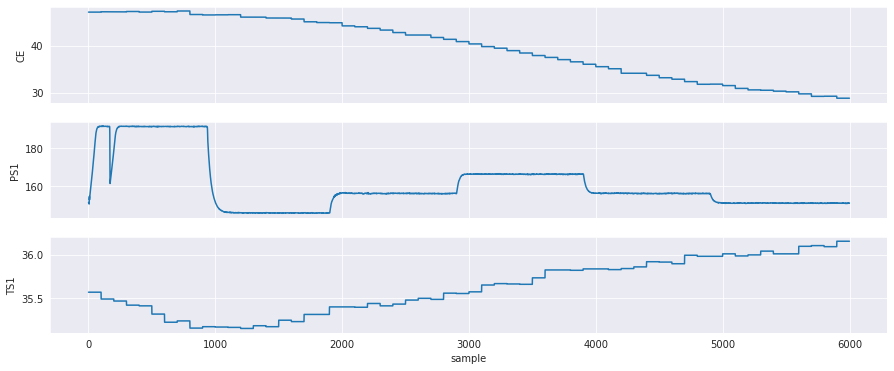

In [22]:
plot_profile(df, profile_id=1, features=["CE", "PS1", "TS1"])

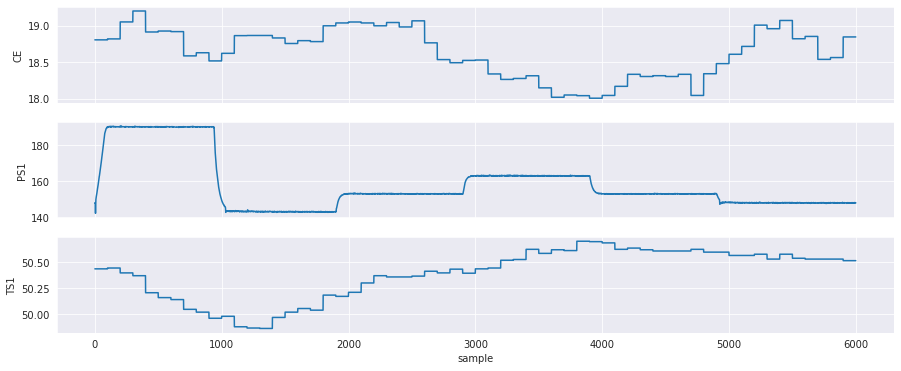

In [23]:
plot_profile(df, profile_id=35, features=["CE", "PS1", "TS1"])

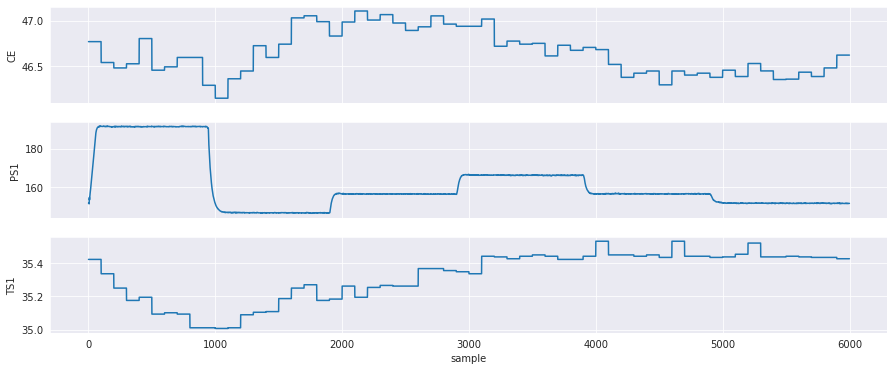

In [24]:
plot_profile(df, profile_id=2205, features=["CE", "PS1", "TS1"])